# Tourament Predictor

In [1]:
# Import Packages
import numpy as np
import pandas as pd
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import log_loss, accuracy_score
from tqdm.notebook import tqdm
import lazypredict
from lazypredict.Supervised import LazyClassifier
import xgboost as xgb
import glob
import os
import gc
from rpy2 import robjects
import PyPDF2
from lightgbm import LGBMClassifier
import cv2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (40,40)
import pandas as pd
from scipy import stats
#import ncaa_simulator
from ncaa_simulator import Data, Submission, Tournament, round_names
import graphviz
import pylab
from IPython.display import Image

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Set Path (Make sure to upate this in your code or it won't run)
PATH = ""
os.chdir(PATH)
print(os.getcwd())

/Users/matthewdenko/Documents/march_madness_kaggle/March_Madness/march_madness_2023


### 2021 Results

In 2021, I leveraged the kaggle input data and combined with kenpom data. I then applied a Gradient Boosting Classifier and predicted the results.

My resulting bracket was pretty decent. It had an overall log loss 0.66587 of which put me at #503 (out of 707) on the Kaggle March Madness prediction leaderboard.

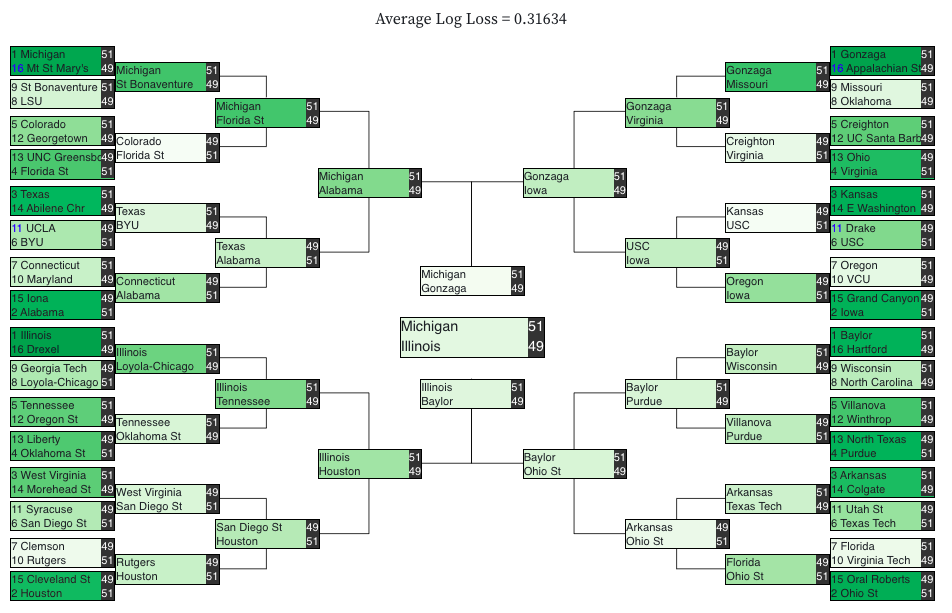

In [3]:
# Printing Bracket
Image(filename='outputs/2021_results.png') 

### 2022 Results

In 2022, I followed a similar method however this time I applied a Gradient Boosting Classifier. My bracket ended up predicting the champion (Kansas) and my braket ended up #143 (out of 930 teams) and a log loss of 0.61624. This was quite a big improvement over previous years, however I think most of this gain is due to predicting the correct champion.

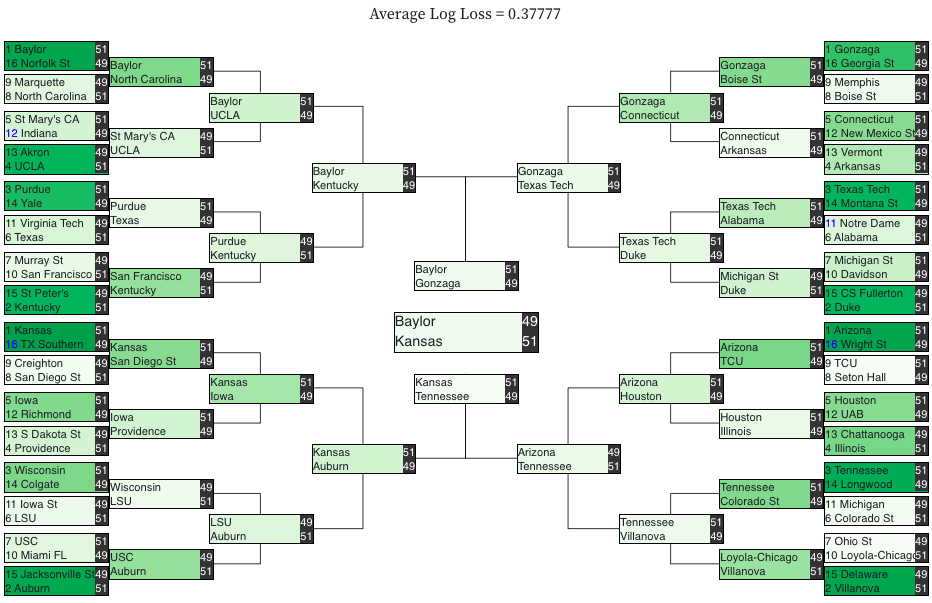

In [4]:
# Printing Bracket
Image(filename='outputs/2022_results.png') 

## 2023 Steps

Now, we are gonna predict the results for each game in the 2023 tourament and print the results (hopefully improving on the past two years)

**Changes From Previous Years**

(1) I used only data from years 2011 and later for this model. I have a suspicion that the years prior add little additional value given how much college basketball has evolved due to transfer/recruiting changes

(2) Fixed Kenmpom Data Leakage. Prior Kenpom data was biased because it took into account tournament results. I used archived pages to get the Kenpom rankings pior to the tournament starting in each year.

(3) Using a LGBMClassifer instead of GBM and Extra Trees Classifiers in previous years. The LazyClassifier model ranked this classifier as having the best predictive capabilities. 

(4) Printed the braket using a different module. The submission file is different this year so I had to find an uglier solution. 

**Steps**

(1) Import Train & Test Sets and combine with Kenpom data

(2) Prepare sets for model training

(3) Use Lazy Predict to test multiple model types

(4) Apply a LGBMClassifier to predict the win probility of each potential game

(5) Analyze Results

## Import Datasets, & Merge with Kenpom

In [5]:
# Loading Datasets
train = pd.read_csv("inputs/tourney.csv")
test = pd.read_csv('inputs/test.csv')
kenpom = pd.read_csv('inputs/kenpom.csv')
kenpom = kenpom.drop(['team'],axis = 1)

In [6]:
# Merging train with Kenpom
train = train.merge(kenpom, how='left', left_on=['Season','TeamID1'],right_on=['year','teamid_x'])
train = train.merge(kenpom, how='left', left_on=['Season','TeamID2'],right_on=['year','teamid_x'])
# Removing Seasons Before 2011 from Analysis
train = train[train.Season >2010]
train = train.drop_duplicates()
train.head()

,Season,TeamID1,TeamID2,result,win_pct_A_1,win_pct_N_1,win_pct_H_1,win_pct_All_1,win_pct_A_2,win_pct_N_2,...,luck_rank_y,sos_pyth_y,sos_pyth_rank_y,sos_oppo_y,sos_oppo_rank_y,sos_oppd_y,sos_oppd_rank_y,ncsos_pyth_y,ncsos_pyth_rank_y,teamid_x_y
512,2011,1155,1412,1,0.30,0.60,0.88,0.66,0.62,0.50,...,144.00,0.59,93.00,103.20,104.00,100.20,97.00,0.48,191.00,1412.00
513,2011,1421,1114,1,0.47,1.00,0.58,0.55,0.23,0.86,...,69.00,0.40,251.00,100.60,209.00,104.30,292.00,0.54,130.00,1114.00
529,2011,1427,1106,1,0.33,1.00,0.73,0.55,0.24,0.75,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
610,2011,1433,1425,1,0.57,0.67,0.79,0.68,0.38,0.50,...,282.00,0.73,27.00,106.80,24.00,97.80,32.00,0.63,54.00,1425.00
866,2011,1139,1330,1,0.54,0.80,0.85,0.71,0.64,1.00,...,24.00,0.55,116.00,103.40,95.00,101.50,150.00,0.58,88.00,1330.00


In [7]:
# Merging test with Kenpom
test = test.merge(kenpom, how='left', left_on=['Season','TeamID1'],right_on=['year','teamid_x'])
test = test.merge(kenpom, how='left', left_on=['Season','TeamID2'],right_on=['year','teamid_x'])
test = test.drop_duplicates()
# Removing Seasons Before 2011 from Analysis
test = test[test.Season >2010]
test.head()

,ID,Season,TeamID1,TeamID2,win_pct_A_1,win_pct_N_1,win_pct_H_1,win_pct_All_1,win_pct_A_2,win_pct_N_2,...,luck_rank_y,sos_pyth_y,sos_pyth_rank_y,sos_oppo_y,sos_oppo_rank_y,sos_oppd_y,sos_oppd_rank_y,ncsos_pyth_y,ncsos_pyth_rank_y,teamid_x_y
0,2023_1101_1102,2023,1101,1102,0.33,0.00,0.50,0.35,0.33,0.00,...,238.00,0.81,119.00,106.40,101.00,105.60,188.00,-10.68,361.00,1102.00
256,2023_1101_1103,2023,1101,1103,0.33,0.00,0.50,0.35,0.45,0.33,...,151.00,-2.13,215.00,104.80,163.00,106.90,262.00,0.24,160.00,1103.00
272,2023_1101_1104,2023,1101,1104,0.33,0.00,0.50,0.35,0.75,0.71,...,32.00,10.37,8.00,109.80,13.00,99.40,10.00,9.44,7.00,1104.00
288,2023_1101_1105,2023,1101,1105,0.33,0.00,0.50,0.35,0.38,0.33,...,154.00,-7.59,343.00,100.30,349.00,107.90,310.00,1.50,120.00,1105.00
304,2023_1101_1106,2023,1101,1106,0.33,0.00,0.50,0.35,0.10,1.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## Prep Data For Model Training

In [8]:
# Setting X & Y for test
y = train["result"]
s = train["Season"]
X = train.drop(['Season','TeamID1','TeamID2','result','teamid_x_y'], axis=1)
X_test = test.drop(['ID', 'Season','TeamID1','TeamID2','teamid_x_y'], axis=1)

In [9]:
# Shaping data
train_oof = np.zeros((X.shape[0],))
test_preds = 0
train_oof.shape

# train test split
NUM_FOLDS = 10
kf = GroupKFold(n_splits=NUM_FOLDS)
max_iter = 550

# Training and running model predictions
for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(X, y, s))):
        #print(f'Fold {f}')
        train_df, val_df = X.iloc[train_ind], X.iloc[val_ind]
        train_target, val_target = y.iloc[train_ind], y.iloc[val_ind]
        train_df = train_df.fillna(0)
        val_df = val_df.fillna(0)

0it [00:00, ?it/s]

In [10]:
# Running Multiple Models to quickly test which classifier is most accurate
clf = LazyClassifier(verbose=0,ignore_warnings=True,custom_metric = log_loss)
models, predictions = clf.fit(train_df,X, train_target,y)
models

100%|██████████| 29/29 [00:11<00:00,  2.57it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,log_loss,Time Taken
Model,,,,,,
LGBMClassifier,0.97,0.97,0.97,0.97,1.03,1.20
XGBClassifier,0.96,0.96,0.96,0.96,1.24,1.46
RandomForestClassifier,0.95,0.95,0.95,0.95,1.57,1.03
DecisionTreeClassifier,0.95,0.95,0.95,0.95,1.60,0.13
ExtraTreesClassifier,0.95,0.95,0.95,0.95,1.67,0.46
BaggingClassifier,0.94,0.94,0.94,0.94,1.97,0.79
ExtraTreeClassifier,0.89,0.89,0.89,0.89,3.64,0.03
NuSVC,0.88,0.88,0.88,0.88,3.99,0.59
LabelSpreading,0.82,0.82,0.82,0.81,6.36,0.29


## Train and Execute Model

Looking at the results above, the LGBMClassifier performed the best this is different from last year's model where the Extra Trees Classifier performed the best. 

Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm

In [11]:
# Setting Model Parameters
NUM_FOLDS = 10
kf = GroupKFold(n_splits=NUM_FOLDS)
max_iter = 550

# Training and running model predictions
for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(X, y, s))):
        #print(f'Fold {f}')
        train_df, val_df = X.iloc[train_ind], X.iloc[val_ind]
        train_target, val_target = y.iloc[train_ind], y.iloc[val_ind]
        train_df = train_df.fillna(0)
        val_df = val_df.fillna(0)
        #model = ExtraTreesClassifier(max_iter=max_iter, validation_fraction=None, learning_rate=0.01, max_depth=2, min_samples_leaf=32)
        model = LGBMClassifier()

        model =  model.fit(train_df, train_target)
        temp_oof = model.predict_proba(val_df)[:,1]
        temp_test = model.predict_proba(X_test)[:,1]

        train_oof[val_ind] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
        print(log_loss(val_target, temp_oof))

0it [00:00, ?it/s]

0.891670031244174
0.5973909417605731
0.813126595057905
0.6304147566656735
0.7124901530947831
0.6086475912130052
0.690232890313903
0.7130332093024588
0.6286374127284253
0.7962507963519194


## Evaluate Model Performance Measures

In [12]:
# Evaluating Log Loss and Accuracy
X = X.fillna(0)
y_preds = model.predict(X)
y_probs = model.predict_proba(X)
loss = log_loss(y, train_oof)
acc = accuracy_score(y,y_preds)
print("Logg Loss:", f'{loss:,.2f}')
print("\nAccuracy Score:", f'{acc:,.2f}')

Logg Loss: 0.72

Accuracy Score: 0.97


The model performance is pretty good. An accuracy score of 97% is very high and the log loss is relatively low as well. Next we are gonna export the predictions for 2023 and see how the bracket looks!

In [13]:
# Saving Probabilities
np.save('train_oof', train_oof)
np.save('test_preds', test_preds)

## Export Kaggle Submission File

In [14]:
# Reading in 2023 data
test = pd.read_csv('inputs/test.csv')
MSampleSubmission = pd.read_csv('inputs/SampleSubmission2023.csv')

In [15]:
# Shaping Predictions for submission file
idx = test_preds.shape[0] //2
test_preds[idx:] = 1 - test_preds[idx:]

pred = pd.concat([test.ID, pd.Series(test_preds)], axis=1).groupby('ID')[0]\
        .mean().reset_index().rename(columns={0:'Pred'})
sub = MSampleSubmission.drop(['Pred'],axis=1).merge(pred, on='ID')
sub.to_csv('outputs/submission2.csv', index=False)
sub.head()


,ID,Pred
0,2023_1101_1102,0.17
1,2023_1101_1103,0.12
2,2023_1101_1104,0.01
3,2023_1101_1105,0.86
4,2023_1101_1106,0.76


## Bracket

In [16]:
## load data
mw = 'M' # or 'W'
ncaa_data = Data(mw, dir='inputs/')
sub_df = pd.read_csv('outputs/submission2.csv')
submission = Submission(sub_df=sub_df, data=ncaa_data)
season = 2023
tourney = Tournament(data=ncaa_data, submission=submission, season=season)

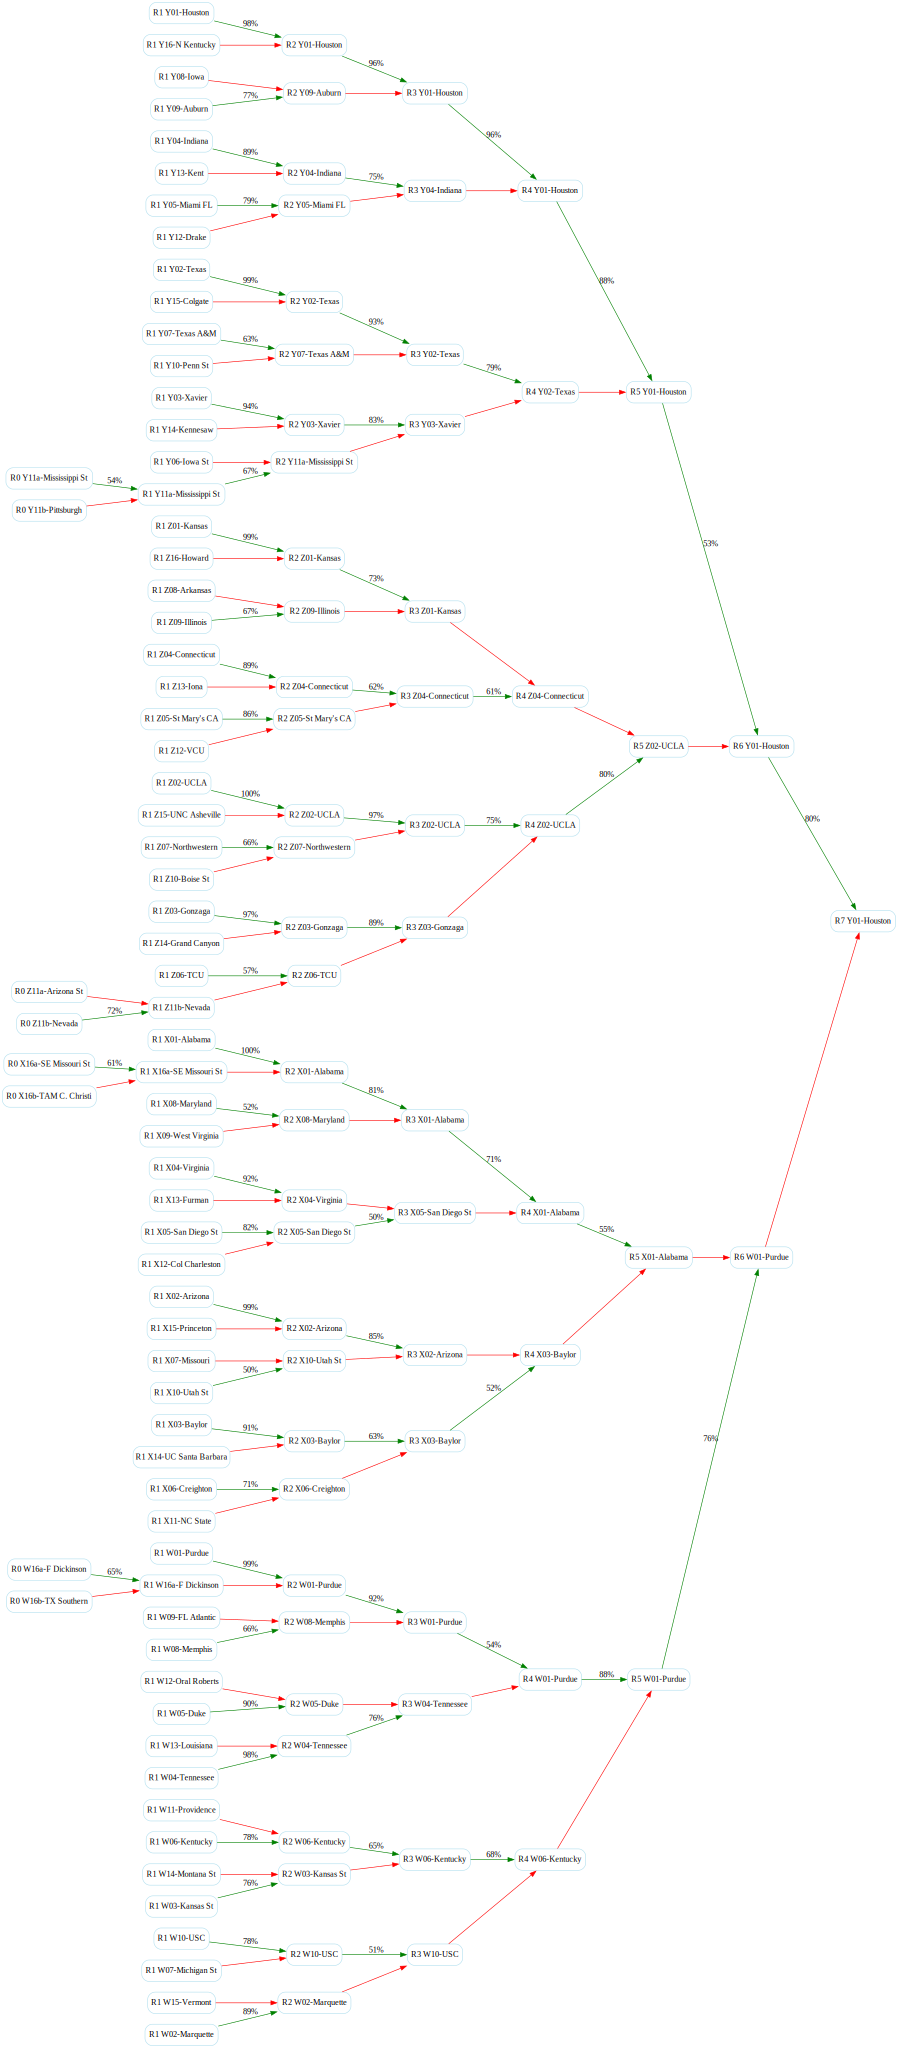

<Figure size 432x288 with 0 Axes>

In [17]:
# Print Bracket
tourney.reset_tournament()
tourney.simulate_tournament(style='chalk') # this runs a chalk bracket where your predicted winner wins every game
# tourney.simulate_tournament(style='random',seed=123) # change the seed to get a different result
graph = tourney.graph_games()
filename = graph.render(filename='outputs/2023_predictions')
pylab.savefig('filename.png')
graph

## Conclusion

The model generated strong results for past touraments (strong accuarcy score, low log loss). However, we can't measure overfit effectively because we don't have the performance of the test set. If I had more time I would split the historical data into a train and test set to help reduce the overfit possiblity, however I wanted to submit my predictions before the tourament started. 

In the end the model predicted very closely to the actual tournament seeds. This is not suprising because many of the same inputs that the tourament takes into consideration when seeding is similar to the input used in this model prediction. This model is what they call in the bracket industry CHALK!

However, this year's predictions are the least CHALKIEST predictions so far. There is a 2 seed (UCLA) predicted to the Final Four and a 6 seed (Kentucky) and 4 seed (UCONN) predicted in the Elite Eight. 

Please do not use this model as betting advice.